# BNL Development Notebook

This notebook is for developing and testing the BNL package.


In [13]:
%load_ext autoreload
%autoreload 2

import bnl

# R2_BUCKET_PUBLIC_URL = "https://pub-05e404c031184ec4bbf69b0c2321b98e.r2.dev"
slm_ds_local = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
# slm_ds_cloud = bnl.data.Dataset(manifest_path=f"{R2_BUCKET_PUBLIC_URL}/manifest_cloud_boolean.csv")
track = next(iter(slm_ds_local))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
## let's get an estimate hierarchy for a track:
# WIP this API should be better.
slm_ds = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
track = slm_ds[3]
# Let's check what annotations are available for this track
print("Available annotations:", list(track.annotations.keys()))

# Try loading an Adobe annotation that exists
est = track.load_annotation("adobe-mu1gamma1")
est

Available annotations: ['adobe-mu1gamma1', 'adobe-mu1gamma9', 'adobe-mu5gamma5', 'reference']


TS(B(0.0)-B(276.63673), adobe-mu1gamma1)

<Axes: title={'center': 'ref-5'}, xlabel='Time (s)'>

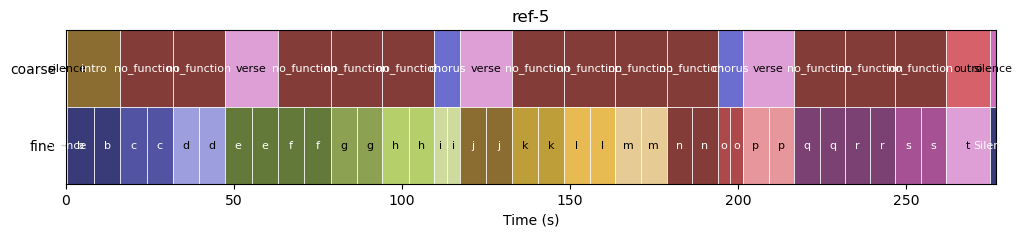

In [15]:
ref = track.load_annotation("reference")
ref.plot(figsize=(12, 2))

<Axes: title={'center': 'adobe-mu1gamma1'}, xlabel='Time (s)'>

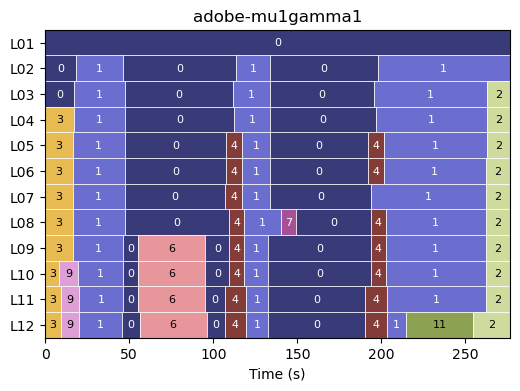

In [16]:
est.plot(figsize=(6,4))
# est[3].plot()

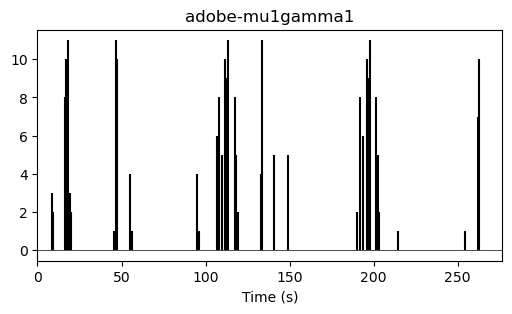

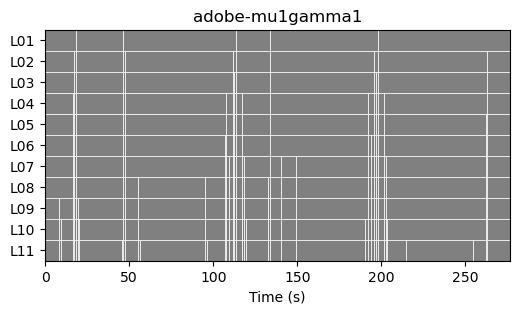

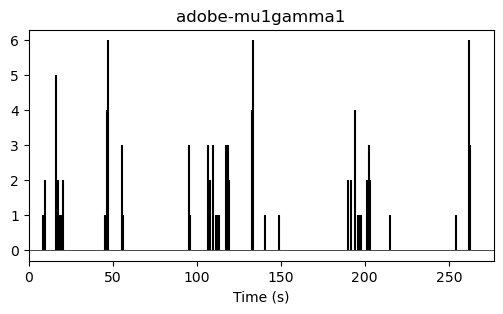

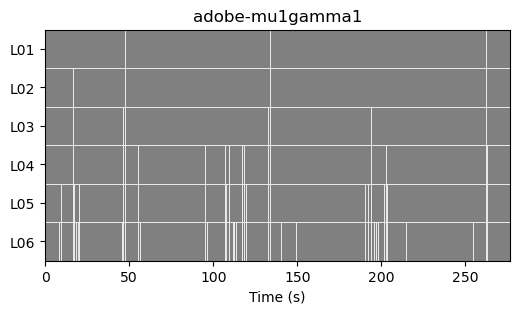

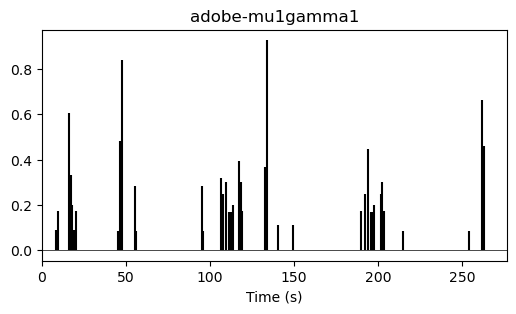

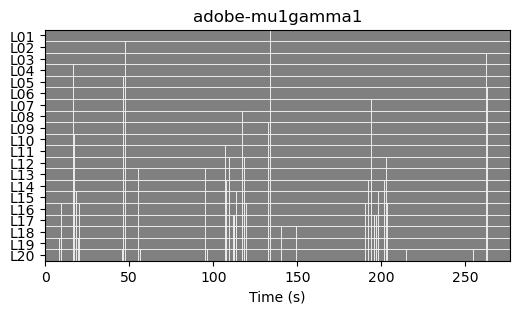

In [17]:
for strategy in ["depth", "count", "prob"]:
    # Using the new fluent API
    contour = est.to_contour(strategy=strategy)
    contour.plot(figsize=(6,3))

    # Convert to hierarchy and then to multisegment for visualization
    hierarchy = contour.to_hierarchy()
    mono_ms = hierarchy.to_multisegment()
    mono_ms.plot(figsize=(6, 3))

Original boundary cleaning strategies:
Original contour has 42 boundaries

Cleaning with absorb strategy:
  Cleaned contour has 29 boundaries

Cleaning with kde strategy:
  Cleaned contour has 19 boundaries


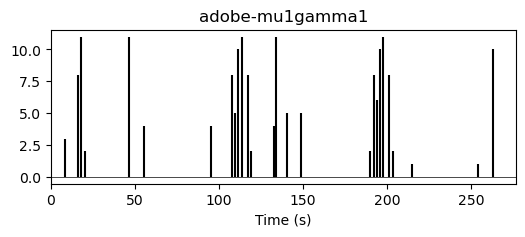

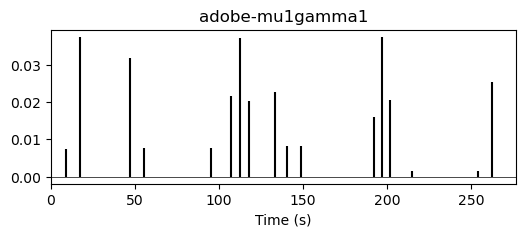

In [33]:
# Demonstrating the new boundary cleaning functionality
print("Original boundary cleaning strategies:")

# Get a boundary contour
contour = est.to_contour(strategy="depth")
print(f"Original contour has {len(contour.boundaries)} boundaries")

# Try different cleaning strategies
for strategy in ["absorb", "kde"]:
    print(f"\nCleaning with {strategy} strategy:")

    if strategy == "absorb":
        # For absorb, we can specify a window parameter
        cleaned = contour.clean(strategy=strategy, window=1.0)
    else:  # kde
        # For kde, we can specify bandwidth and frame_size
        cleaned = contour.clean(strategy=strategy, bandwidth=1.0, frame_size=0.1)

    print(f"  Cleaned contour has {len(cleaned.boundaries)} boundaries")
    cleaned.plot(figsize=(6, 2))


Original boundary cleaning strategies:
Original contour has 42 boundaries

Cleaning with absorb strategy:
  Cleaned contour has 29 boundaries

Cleaning with kde strategy:
  Cleaned contour has 19 boundaries


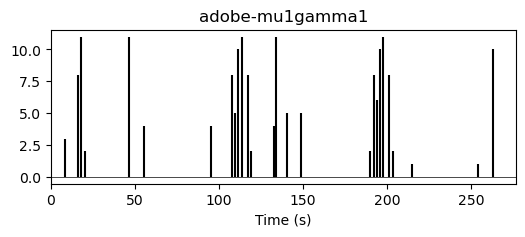

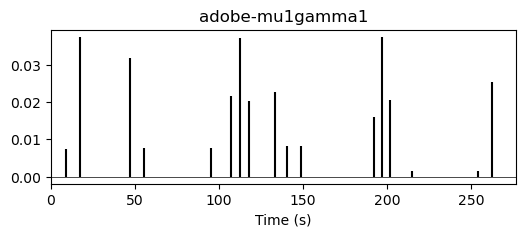

In [34]:
# Demonstrating the new boundary cleaning functionality
print("Original boundary cleaning strategies:")

# Get a boundary contour
contour = est.to_contour(strategy="depth")
print(f"Original contour has {len(contour.boundaries)} boundaries")

# Try different cleaning strategies
for strategy in ["absorb", "kde"]:
    print(f"\nCleaning with {strategy} strategy:")
    
    if strategy == "absorb":
        # For absorb, we can specify a window parameter
        cleaned = contour.clean(strategy=strategy, window=1.0)
    else:  # kde
        # For kde, we can specify bandwidth and frame_size
        cleaned = contour.clean(strategy=strategy, bandwidth=1.0, frame_size=0.1)
    
    print(f"  Cleaned contour has {len(cleaned.boundaries)} boundaries")
    cleaned.plot(figsize=(6, 2))


Original boundary cleaning strategies:
Original contour has 42 boundaries

Cleaning with absorb strategy:
  Cleaned contour has 29 boundaries

Cleaning with kde strategy:
  Cleaned contour has 19 boundaries


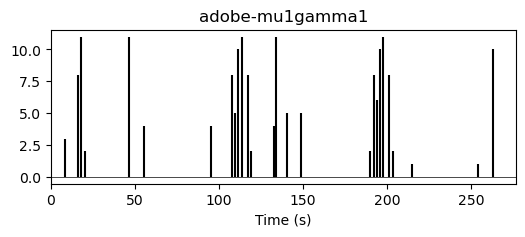

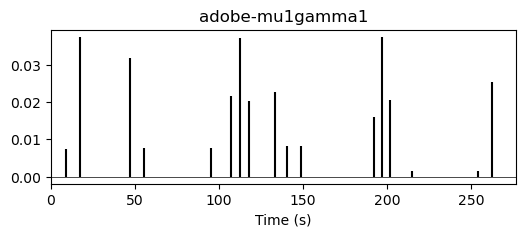

In [35]:
# Demonstrating the new boundary cleaning functionality
print("Original boundary cleaning strategies:")

# Get a boundary contour
contour = est.to_contour(strategy="depth")
print(f"Original contour has {len(contour.boundaries)} boundaries")

# Try different cleaning strategies
for strategy in ["absorb", "kde"]:
    print(f"\nCleaning with {strategy} strategy:")
    
    if strategy == "absorb":
        # For absorb, we can specify a window parameter
        cleaned = contour.clean(strategy=strategy, window=1.0)
    else:  # kde
        # For kde, we can specify bandwidth and frame_size
        cleaned = contour.clean(strategy=strategy, bandwidth=1.0, frame_size=0.1)
    
    print(f"  Cleaned contour has {len(cleaned.boundaries)} boundaries")
    cleaned.plot(figsize=(6, 2))


Fluent API chaining - the full pipeline in one expression:
Final result has 11 layers


<Axes: title={'center': 'adobe-mu1gamma1'}, xlabel='Time (s)'>

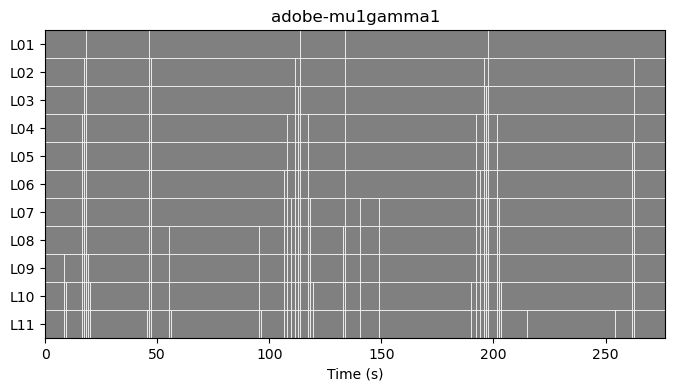

In [36]:
# Demonstrating the beautiful fluent API chaining
print("Fluent API chaining - the full pipeline in one expression:")

# The complete pipeline: estimate -> contour -> clean -> hierarchy -> multisegment
final_result = (
    est.to_contour(strategy="depth")
       .clean(strategy="absorb", window=0.5)
       .to_hierarchy()
       .to_multisegment()
)

print(f"Final result has {len(final_result)} layers")
final_result.plot(figsize=(8, 4))
